In [1183]:
from covid_api import CovidAPI, APIHelper
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import datetime as dt
import requests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()

In [1179]:
#loading dataset

def load_csv(file_name):
    return pd.read_csv('../data/' + file_name)

df_countries_and_continents = load_csv('country-and-continent-codes-list-csv_csv.csv')
del df_countries_and_continents['Unnamed: 0']

df_covid_cases = load_csv('covid_cases.csv')
df_covid_cases['date'] = pd.to_datetime(df_covid_cases['date'])
del df_covid_cases['Unnamed: 0']

covid_summaries = load_csv('covid_summaries.csv')
del covid_summaries['Unnamed: 0']

df_continents = df_countries_and_continents.copy()
del df_continents['country_code']
df_continents.drop_duplicates(inplace=True)

df_countries = df_countries_and_continents.copy()
del df_countries['continent_name']
del df_countries['continent_code']
df_countries.drop_duplicates(inplace=True)

df_owid_covid = load_csv('covid-data.csv')

## Covid-19 cases count
 

In [1026]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y %m')

def get_dates_between(sdate, edate):
    dates = []
    delta = edate - sdate # as timedelta

    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        dates.append(day)
    
    return dates
    

def covid_lineplot(covid_deaths, covid_confirmed, covid_recovered, title):
    fig, ax = plt.subplots()

    ax.plot(covid_deaths, color='red')
    ax.plot(covid_confirmed, color='blue')
    ax.plot(covid_recovered, color='green')
    ax.legend(('deaths', 'confirmed', 'recovered'),fontsize=15)

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    
    # round to nearest years.
    covid_confirmed.index[-1]
    datemin = np.datetime64(covid_confirmed.index[0], 'Y')
    datemax = np.datetime64(covid_confirmed.index[-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)

    #shadow under curves
    dates = get_dates_between(covid_confirmed.index[0], covid_confirmed.index[-1])
    ax.fill_between(dates, 0, covid_confirmed.tolist(), facecolor='blue', alpha=0.25)
    dates = get_dates_between(covid_recovered.index[0], covid_recovered.index[-1])
    ax.fill_between(dates, 0, covid_recovered.tolist(), facecolor='green', alpha=0.25)
    dates = get_dates_between(covid_deaths.index[0], covid_deaths.index[-1])
    ax.fill_between(dates, 0, covid_deaths.tolist(), facecolor='red', alpha=0.25)
    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    ax.set_title(title,fontsize=15)
    ax.set_xlabel('date',fontsize=15)
    ax.set_ylabel('cases',fontsize=15)
    
    #drawing vertical line that shows Covid-19 as pandemic
    plt.axvline(dt.datetime(2020, 3, 11),color='black',linestyle='--')
    x_text_annotation = dt.datetime(2020, 3, 11)
    y_pos = covid_confirmed[-1] * .9
    ax.text(x=x_text_annotation, y=y_pos, s='WHO declared Covid-19 a pandemic', color='#334f8d',fontsize=15)

    # rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them
    fig.autofmt_xdate()

    fig.set_size_inches(15.5, 10.5)

    plt.show()


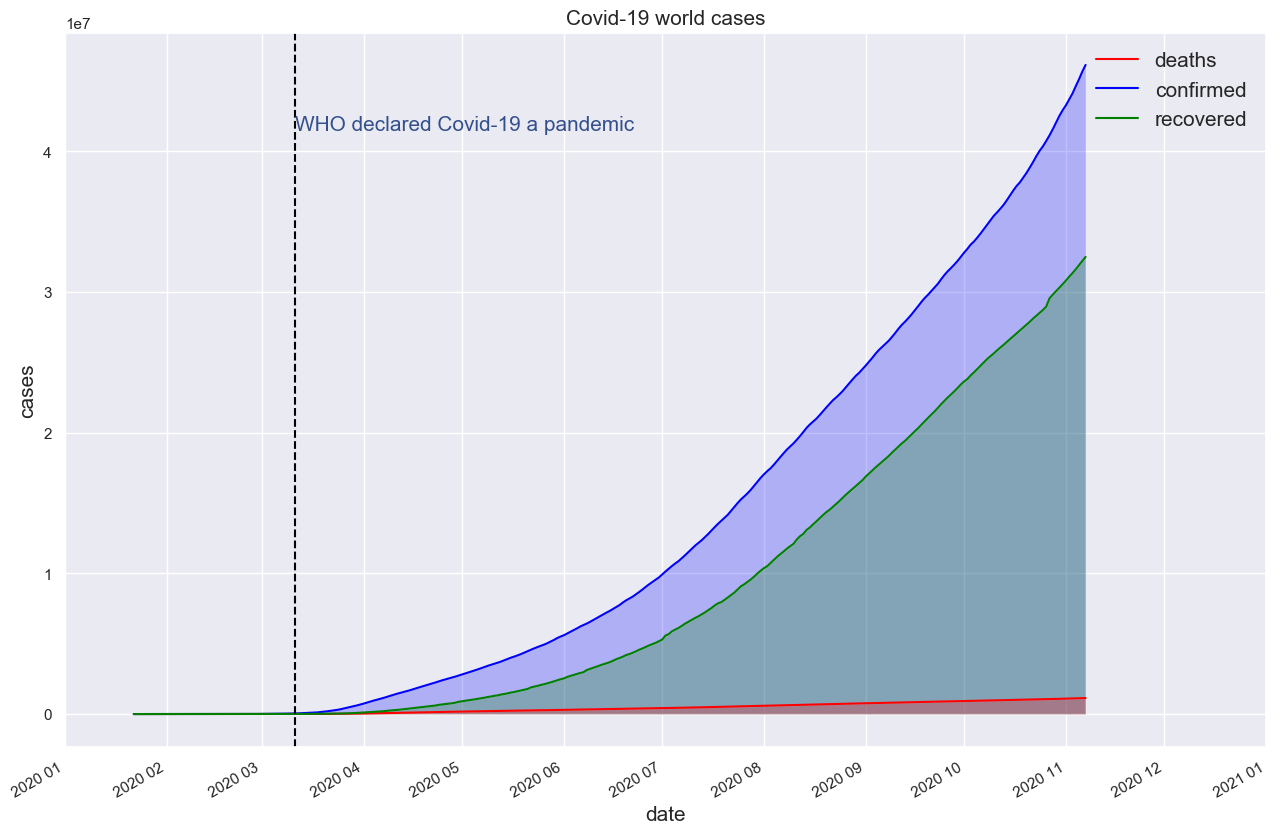

In [1003]:
covid_by_date = df_covid_cases.groupby('date').sum()
covid_deaths = covid_by_date.deaths
covid_confirmed = covid_by_date.confirmed
covid_recovered = covid_by_date.recovered

covid_lineplot(covid_deaths, covid_confirmed, covid_recovered, 'Covid-19 world cases')

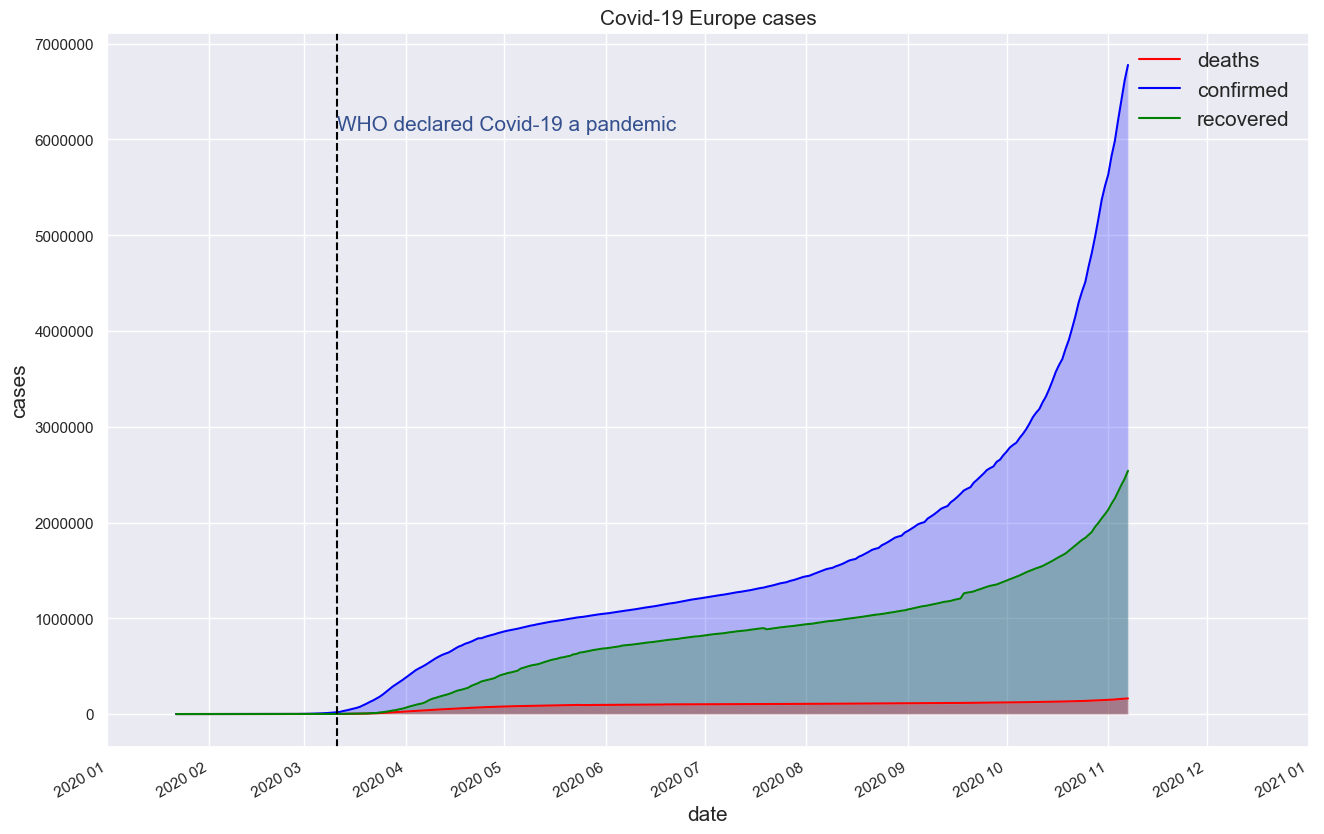

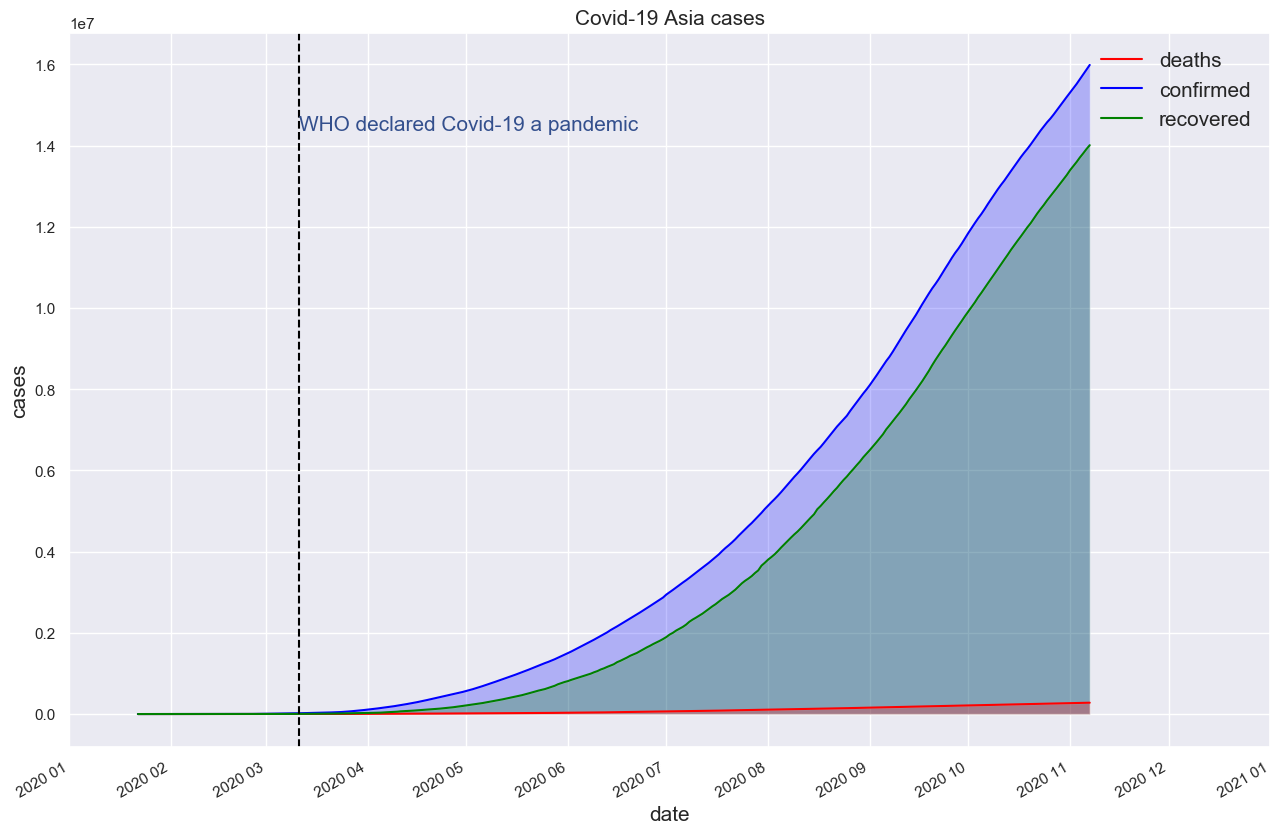

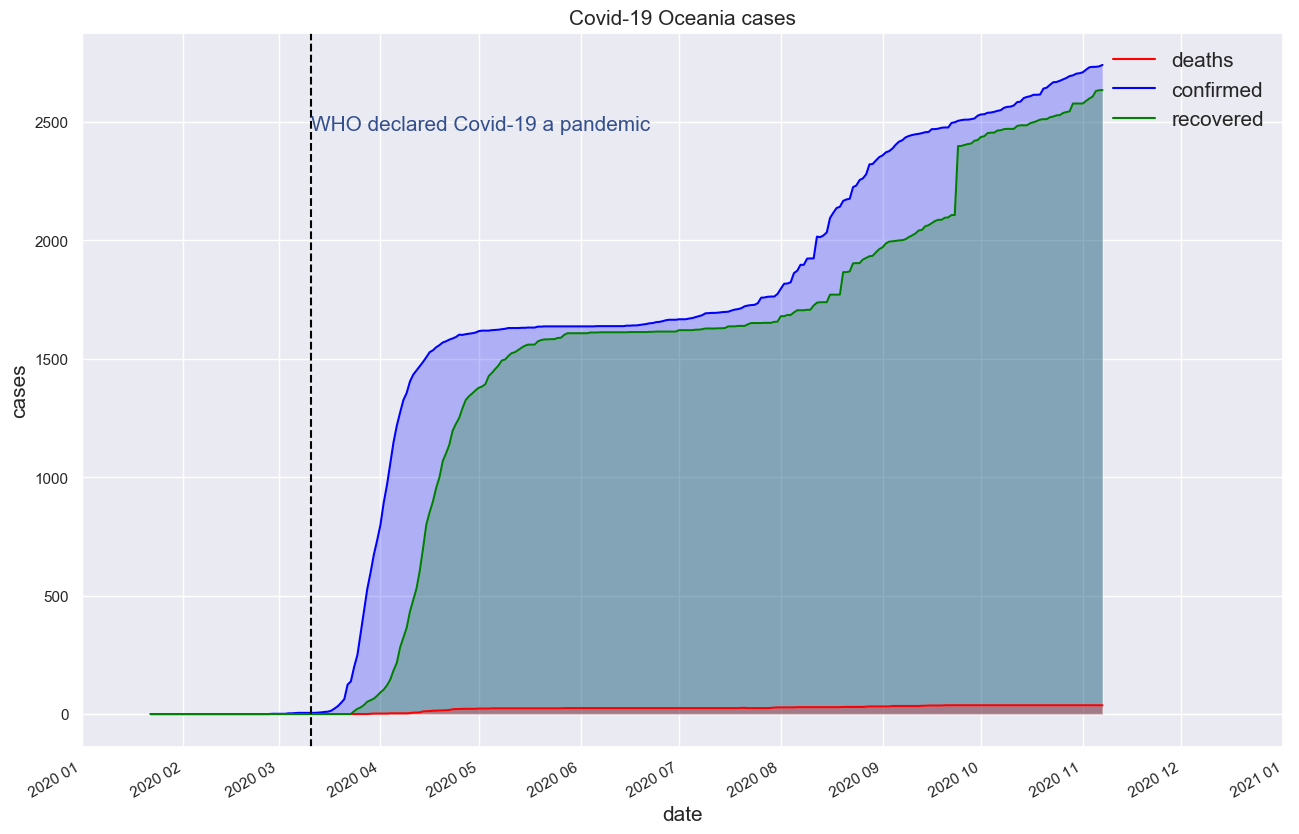

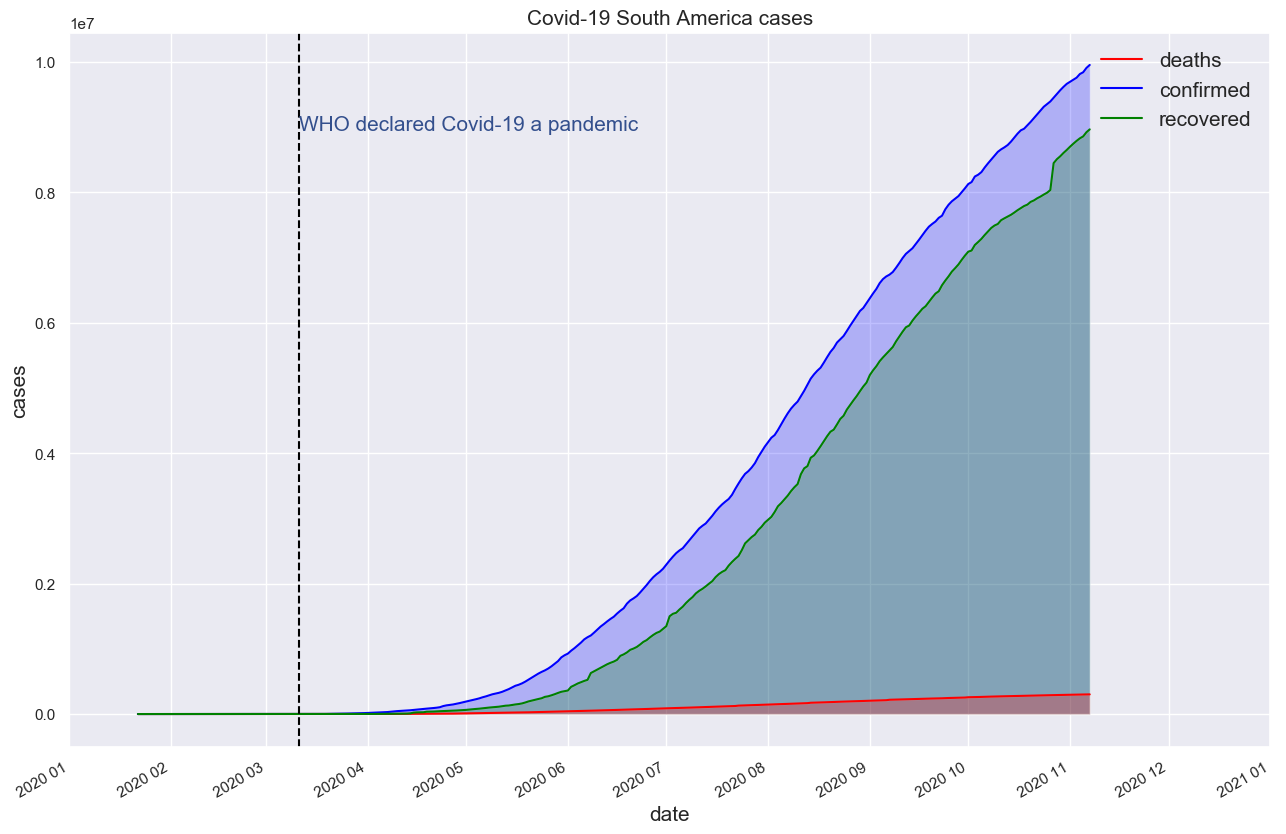

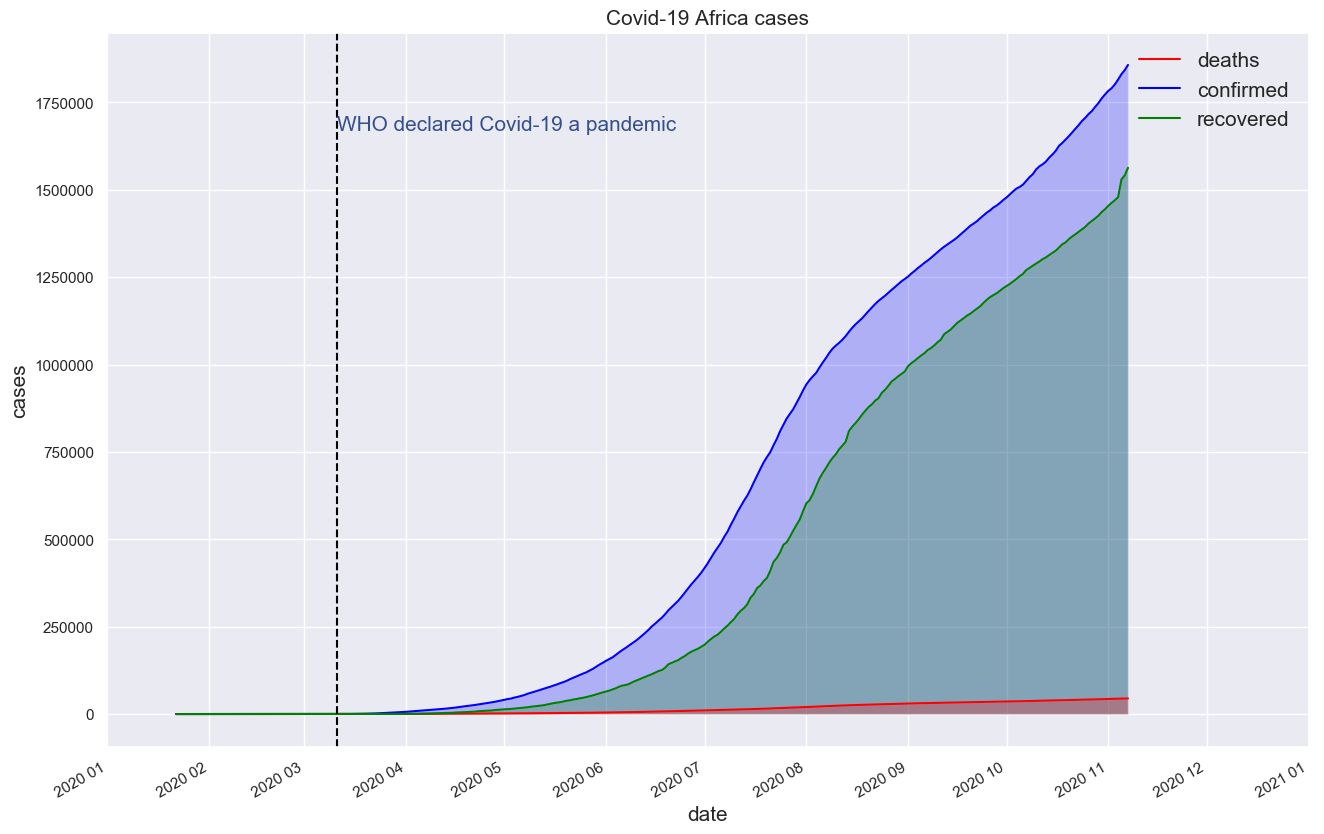

In [1028]:
def look_continent_name(key):
    for i in range(0,len(df_continents)):
        item = df_continents.iloc[i]
        if item.continent_code == key:
            return item.continent_name

for continent_key in list(set(df_covid_cases.continent_code.dropna())):
    df_covid_cases_per_continent = df_covid_cases[df_covid_cases.continent_code == continent_key]
    covid_by_date = df_covid_cases_per_continent.groupby('date').sum()
    covid_deaths = covid_by_date.deaths
    covid_confirmed = covid_by_date.confirmed
    covid_recovered = covid_by_date.recovered
    
    title = 'Covid-19 ' + look_continent_name(continent_key) + ' cases'
    covid_lineplot(covid_deaths, covid_confirmed, covid_recovered, title)

## Top N death, confirmed and recovered countries count

In [1180]:
def look_country_name(key):
    for i in range(0,len(df_countries)):
        item = df_countries.iloc[i]
        if item.country_code == key:
            return item.country_name


def bar_plot(df, sort_key, ylabel_title, first_n, ascending=False):
    df_first_n = df.sort_values([sort_key], ascending=ascending)[:first_n]
    
    #mapping country code to country name
    objects = []
    for country_code in df_first_n.country_code.tolist():
        objects.append(look_country_name(country_code))

    x_pos = np.arange(len(objects))
    performance = df_first_n[sort_key].tolist()
    
    plt.bar(x_pos, performance, align='center', alpha=0.5,color='b')
    plt.xticks(x_pos, objects,rotation=40, fontsize=9)
        
    plt.ylabel(ylabel_title)
    plt.xlabel('Countries')
    plt.title('population ' + sort_key)
    
    fig.autofmt_xdate()

    plt.show()

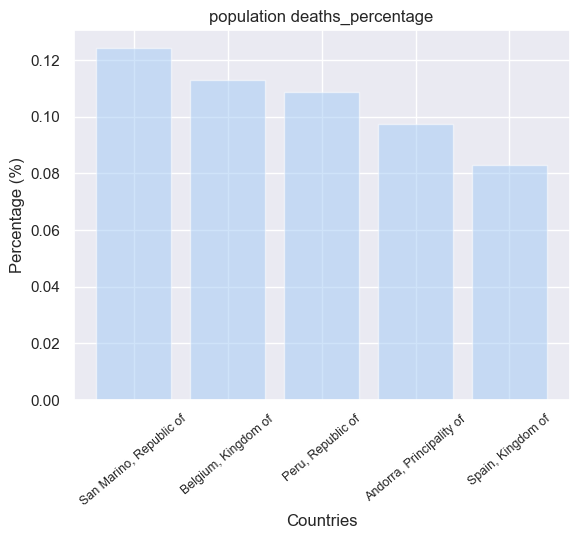

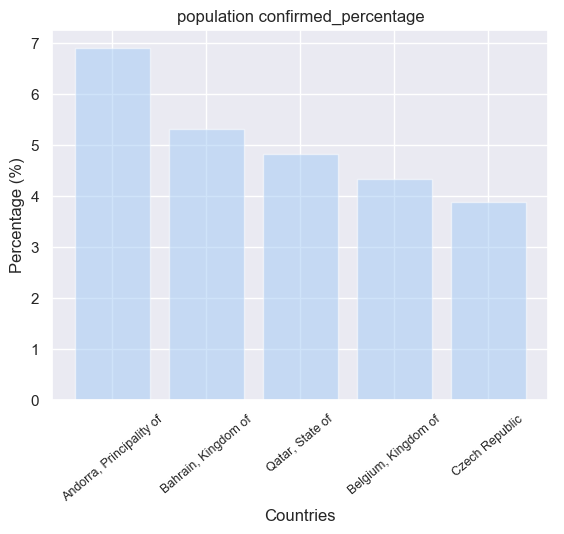

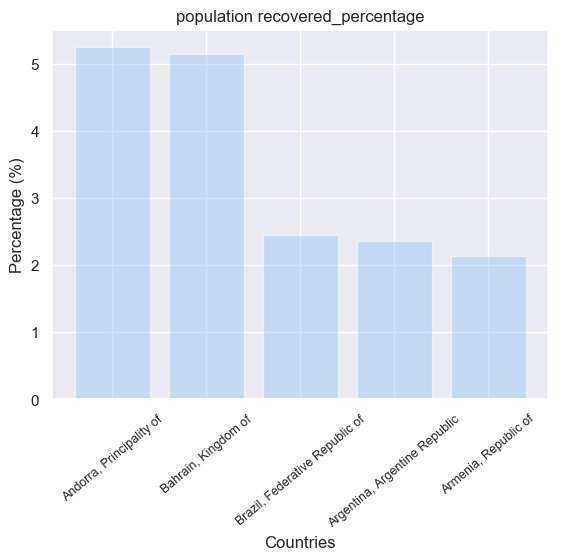

In [1181]:
keys = ['deaths_percentage', 'confirmed_percentage', 'recovered_percentage']
for key in keys:
    bar_plot(covid_summaries, key, ylabel_title='Percentage (%)', first_n=5)

In [1186]:
total_cases = df_owid_covid.groupby('location')['new_cases'].sum()
total_cases = total_cases.sort_values(ascending=False)

most_affected_countries = total_cases[1:11].index # Top 10 Most Affected Countries
most_affected_countries

Index([u'United States', u'India', u'Brazil', u'France', u'Russia', u'Spain',
       u'Argentina', u'United Kingdom', u'Colombia', u'Mexico'],
      dtype='object', name=u'location')

In [1187]:
cases = total_cases[1:11].values # Number of Cases in Top 10 Countries 

total_deaths = df_owid_covid.groupby('location')['new_deaths'].sum()
deaths = total_deaths[most_affected_countries].values # Number of Deaths in Top 10 Countries

cases_deaths_df = pd.DataFrame({'Country': most_affected_countries, 'Total Cases': cases, 'Total Deaths': deaths})
print(cases_deaths_df)

          Country     Total Cases  Total Deaths
0   United States 9,971,651.00000 237,572.00000
1           India 8,553,657.00000 126,611.00000
2          Brazil 5,590,025.00000 161,106.00000
3          France 1,787,324.00000  40,439.00000
4          Russia 1,774,334.00000  30,537.00000
5           Spain 1,328,832.00000  38,833.00000
6       Argentina 1,242,169.00000  33,560.00000
7  United Kingdom 1,192,013.00000  49,044.00000
8        Colombia 1,143,887.00000  32,791.00000
9          Mexico   967,825.00000  95,027.00000


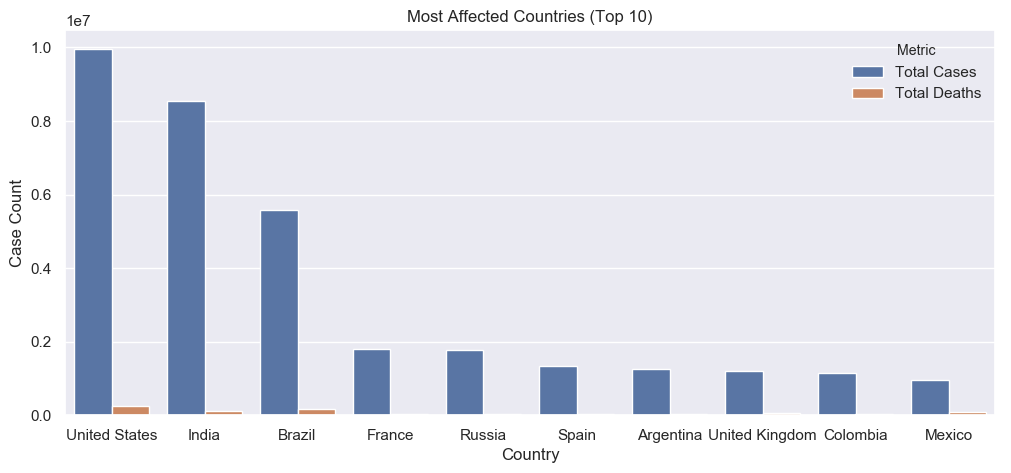

In [1166]:
plot_data = pd.melt(cases_deaths_df, id_vars = ['Country'],  value_vars=['Total Cases', 'Total Deaths'], 
                    var_name='Metric', value_name='Case Count')
plt.figure(figsize=(12, 5))
sns.barplot(x="Country", hue="Metric", y="Case Count", data=plot_data)
plt.title('Most Affected Countries (Top 10)')
plt.show()

### deaths, recovered and confirmed around the world

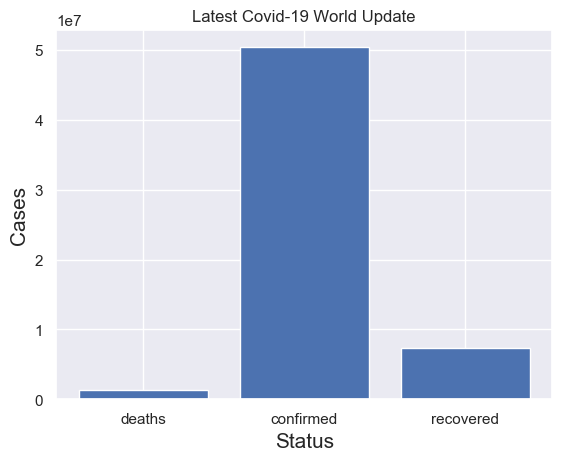

In [1189]:
#default source parameter "jhu"
resp_latest = CovidAPI.get_task('/v2/latest')['latest']
objects = ['deaths', 'confirmed', 'recovered']
x_pos = np.arange(len(objects))
performance = [resp_latest['deaths'], resp_latest['confirmed'], resp_latest['recovered']]

plt.bar(x_pos, performance, align='center', color='b')

plt.xticks(x_pos, objects)
plt.ylabel('Cases', fontsize=15)
plt.xlabel('Status', fontsize=15)
plt.title('Latest Covid-19 World Update')

plt.show()

## Testing rate 

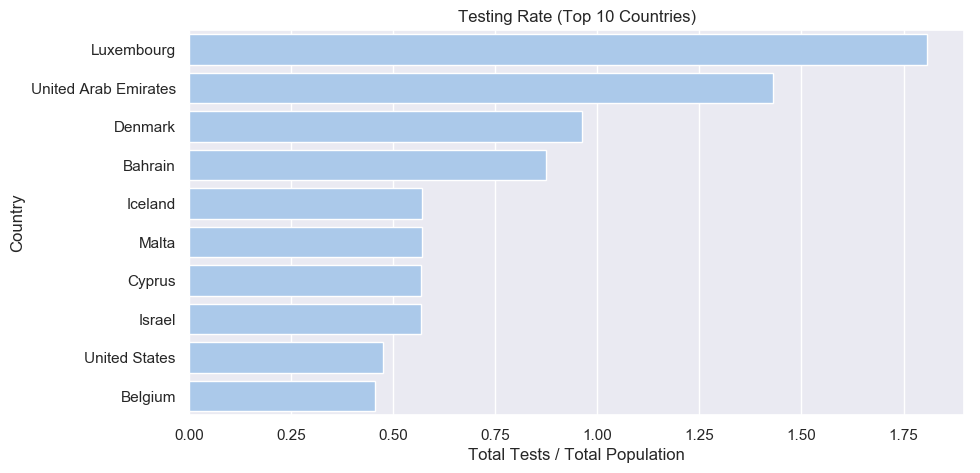

In [1192]:
total_tests = df_owid_covid.groupby('location')['new_tests'].sum().values
population = df_owid_covid.groupby('location')['population'].nth(-1)
testing_rate = (total_tests/population).sort_values(ascending = False)[:10]

plt.figure(figsize=(10, 5))
sns.set_color_codes("pastel")
sns.barplot(y = testing_rate.index, x = testing_rate.values, orient = "h", color="b")
plt.title('Testing Rate (Top 10 Countries)')
plt.xlabel('Total Tests / Total Population')
plt.ylabel('Country')
plt.show()